# Plant Disease Detection

#### Import the required libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

#### Load the dataset

In [2]:
data_dir = r"C:\Users\krish\OneDrive\Desktop\Projects\Plant Disease Detection\Dataset"
print(os.listdir("Dataset"))

['Diseased', 'Healthy']


#### Preprocessing the data

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 329 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


In [4]:
class_labels = train_generator.class_indices
print("Class labels:", class_labels)
classes = list(train_generator.class_indices.keys())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights)

Class labels: {'Diseased': 0, 'Healthy': 1}
Class weights: {0: 0.5633561643835616, 1: 4.445945945945946}


#### Model building using pre-trained ResNet50

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

#### Model training

In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 349s 27s/step - accuracy: 0.4705 - loss: 0.9094 - val_accuracy: 0.1250 - val_loss: 0.9809
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 558ms/step - accuracy: 0.5938 - loss: 0.6506 - val_accuracy: 0.0588 - val_loss: 1.0019
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 205s 20s/step - accuracy: 0.6399 - loss: 0.6417 - val_accuracy: 0.1094 - val_loss: 0.8515
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 314ms/step - accuracy: 0.7188 - loss: 0.4741 - val_accuracy: 0.1176 - val_loss: 0.8396
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 186s 19s/step - accuracy: 0.7277 - loss: 0.4557 - val_accuracy: 0.0625 - val_loss: 0.7407
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 293ms/step - accuracy: 0.7188 - loss: 0.4642 - val_accuracy: 0.1765 - val_loss: 0.7124
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 177s 18s/step - accuracy: 0.8032 - loss: 0.4298 - val_accuracy: 0.8750 - val_loss: 0.5371
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 319ms/step - accuracy: 0.8750 - loss: 0.2104 - val_accuracy

#### Evaluation

In [8]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy:}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8780 - loss: 0.4564
Validation Loss: 0.44827863574028015
Validation Accuracy: 0.8888888955116272


In [17]:
validation_generator.reset()  
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten() 
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'The accuracy of the model is: {accuracy:.4f}')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
The accuracy of the model is: 0.8889
              precision    recall  f1-score   support

    Diseased       0.89      1.00      0.94        72
     Healthy       0.00      0.00      0.00         9

    accuracy                           0.89        81
   macro avg       0.44      0.50      0.47        81
weighted avg       0.79      0.89      0.84        81



#### Visualizing training accuracy and loss over epochs

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

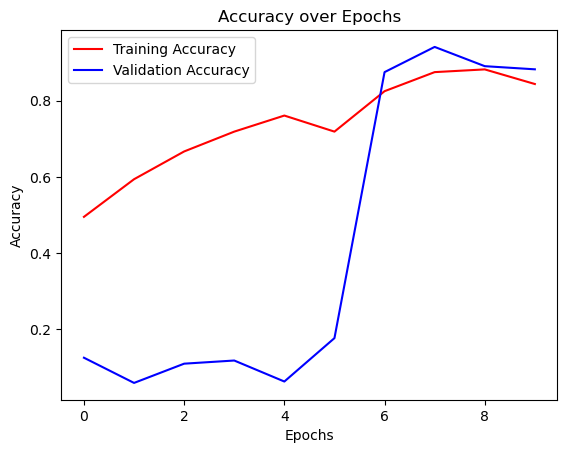

In [19]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

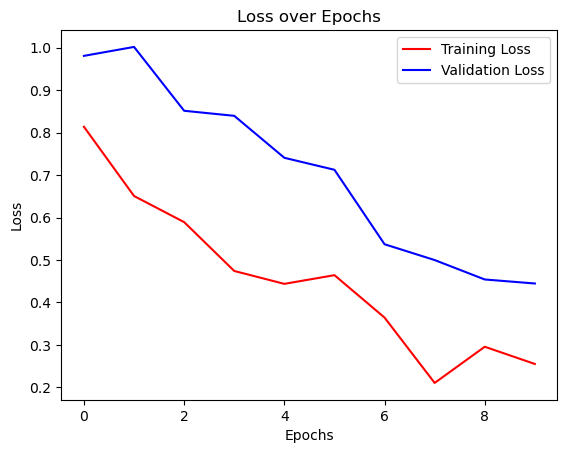

In [20]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Model Prediction

In [34]:
def predict_image(image_path, model, target_size=(224, 224), display_size=(256, 256)):

    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0 

    prediction = model.predict(img_array)
    predicted_class = (prediction > 0.5).astype(int)[0][0] 

    disease_types = ['Diseased', 'Healthy']
    predicted_disease = disease_types[predicted_class]
    confidence = prediction[0][0] if predicted_class == 1 else 1 - prediction[0][0]

    img_original = cv2.imread(image_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_original, display_size, interpolation=cv2.INTER_LINEAR)

    plt.imshow(img_resized)
    plt.title(f"Predicted: {predicted_disease}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

    return predicted_disease, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


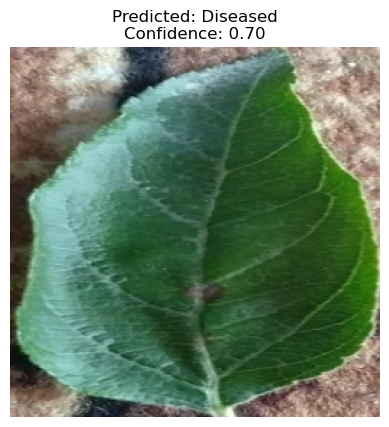

In [35]:
image_path = r"C:\Users\krish\OneDrive\Desktop\Projects\Plant Disease Detection\Dataset\Diseased\1012.JPG.jpeg"
disease, confidence = predict_image(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


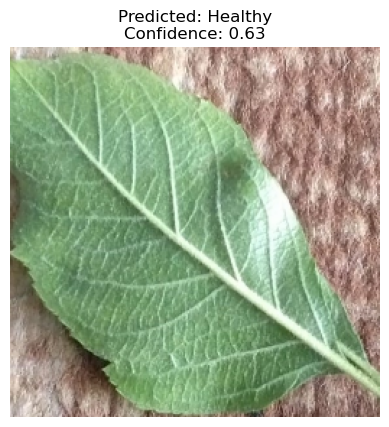

In [33]:
image_path = r"C:\Users\krish\OneDrive\Desktop\Projects\Plant Disease Detection\Dataset\Healthy\1002.jpg.jpeg"
disease, confidence = predict_image(image_path, model)